In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[14].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.69it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.03it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 14/2000 [00:00<01:15, 26.33it/s]

Epoch 10/2000, Loss: 0.5426
Test Accuracy at Epoch 10: 64.74%
Test F1-score at Epoch 10: 0.6884
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.59       194
non_infringement       0.61      0.80      0.69       186

        accuracy                           0.65       380
       macro avg       0.66      0.65      0.64       380
    weighted avg       0.66      0.65      0.64       380

New best model saved with F1-score 0.6884 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.72      0.51      0.59       194
non_infringement       0.61      0.80      0.69       186

        accuracy                           0.65       380
       macro avg       0.66      0.65      0.64       380
    weighted avg       0.66      0.65      0.64       380



Training Epochs:   1%|▏         | 27/2000 [00:01<01:00, 32.42it/s]

Epoch 20/2000, Loss: 0.3981
Test Accuracy at Epoch 20: 68.68%
Test F1-score at Epoch 20: 0.7187
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.56      0.65       194
non_infringement       0.64      0.82      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380

New best model saved with F1-score 0.7187 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.56      0.65       194
non_infringement       0.64      0.82      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:   2%|▏         | 31/2000 [00:01<00:58, 33.81it/s]

Epoch 30/2000, Loss: 0.3392
Test Accuracy at Epoch 30: 73.95%
Test F1-score at Epoch 30: 0.7637
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.86      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

New best model saved with F1-score 0.7637 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.82      0.62      0.71       194
non_infringement       0.69      0.86      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:   2%|▏         | 47/2000 [00:01<00:45, 43.03it/s]

Epoch 40/2000, Loss: 0.3076
Test Accuracy at Epoch 40: 72.11%
Test F1-score at Epoch 40: 0.7512
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.59      0.68       194
non_infringement       0.67      0.86      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.72      0.72       380
    weighted avg       0.74      0.72      0.72       380

Epoch 50/2000, Loss: 0.2818
Test Accuracy at Epoch 50: 72.89%
Test F1-score at Epoch 50: 0.7621
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.72       380
    weighted avg       0.76      0.73      0.72       380



Training Epochs:   3%|▎         | 63/2000 [00:01<00:43, 44.39it/s]

Epoch 60/2000, Loss: 0.2582
Test Accuracy at Epoch 60: 73.68%
Test F1-score at Epoch 60: 0.7706
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.86      0.58      0.69       194
non_infringement       0.67      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.74      0.73       380

New best model saved with F1-score 0.7706 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.86      0.58      0.69       194
non_infringement       0.67      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.74      0.73       380

Epoch 70/2000, Loss: 0.2216


Training Epochs:   4%|▍         | 75/2000 [00:02<00:42, 45.41it/s]

Test Accuracy at Epoch 70: 73.42%
Test F1-score at Epoch 70: 0.7657
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.84      0.59      0.69       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:   4%|▍         | 85/2000 [00:02<00:41, 45.98it/s]

Epoch 80/2000, Loss: 0.1938
Test Accuracy at Epoch 80: 76.32%
Test F1-score at Epoch 80: 0.7816
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380

New best model saved with F1-score 0.7816 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:   5%|▍         | 95/2000 [00:02<00:42, 45.01it/s]

Epoch 90/2000, Loss: 0.1719
Test Accuracy at Epoch 90: 73.42%
Test F1-score at Epoch 90: 0.7646
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.84      0.59      0.69       194
non_infringement       0.67      0.88      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:   5%|▌         | 108/2000 [00:02<00:36, 51.47it/s]

Epoch 100/2000, Loss: 0.1581
Test Accuracy at Epoch 100: 73.95%
Test F1-score at Epoch 100: 0.7714
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.86      0.59      0.70       194
non_infringement       0.68      0.90      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.74      0.73       380
    weighted avg       0.77      0.74      0.73       380

Epoch 110/2000, Loss: 0.1518


Training Epochs:   6%|▌         | 114/2000 [00:02<00:42, 44.72it/s]

Test Accuracy at Epoch 110: 77.11%
Test F1-score at Epoch 110: 0.7862
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.75       194
non_infringement       0.72      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

New best model saved with F1-score 0.7862 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.75       194
non_infringement       0.72      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 120/2000, Loss: 0.1424


Training Epochs:   6%|▋         | 127/2000 [00:03<00:36, 51.00it/s]

Test Accuracy at Epoch 120: 73.68%
Test F1-score at Epoch 120: 0.7674
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.85      0.59      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:   7%|▋         | 139/2000 [00:03<00:37, 49.02it/s]

Epoch 130/2000, Loss: 0.1372
Test Accuracy at Epoch 130: 75.00%
Test F1-score at Epoch 130: 0.7765
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 140/2000, Loss: 0.1324
Test Accuracy at Epoch 140: 75.00%
Test F1-score at Epoch 140: 0.7765
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:   8%|▊         | 157/2000 [00:03<00:38, 48.25it/s]

Epoch 150/2000, Loss: 0.1306
Test Accuracy at Epoch 150: 75.79%
Test F1-score at Epoch 150: 0.7788
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.84      0.65      0.73       194
non_infringement       0.70      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 160/2000, Loss: 0.1265
Test Accuracy at Epoch 160: 75.53%
Test F1-score at Epoch 160: 0.7759
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.83      0.65      0.73       194
non_infringement       0.70      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.76      0.75       380



Training Epochs:   9%|▊         | 174/2000 [00:04<00:45, 40.39it/s]

Epoch 170/2000, Loss: 0.1241
Test Accuracy at Epoch 170: 77.63%
Test F1-score at Epoch 170: 0.7922
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.77       380

New best model saved with F1-score 0.7922 at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:   9%|▉         | 184/2000 [00:04<00:45, 39.52it/s]

Epoch 180/2000, Loss: 0.1220
Test Accuracy at Epoch 180: 74.21%
Test F1-score at Epoch 180: 0.7678
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       194
non_infringement       0.69      0.87      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  10%|▉         | 197/2000 [00:04<00:36, 49.03it/s]

Epoch 190/2000, Loss: 0.1202
Test Accuracy at Epoch 190: 77.37%
Test F1-score at Epoch 190: 0.7892
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.78      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 200/2000, Loss: 0.1185
Test Accuracy at Epoch 200: 77.89%
Test F1-score at Epoch 200: 0.7931
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  10%|█         | 203/2000 [00:04<00:43, 41.55it/s]

New best model saved with F1-score 0.7931 at epoch 200
Best Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.84      0.70      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  11%|█         | 214/2000 [00:05<00:38, 46.46it/s]

Epoch 210/2000, Loss: 0.1210
Test Accuracy at Epoch 210: 74.47%
Test F1-score at Epoch 210: 0.7718
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.84      0.61      0.71       194
non_infringement       0.69      0.88      0.77       186

        accuracy                           0.74       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  11%|█         | 224/2000 [00:05<00:39, 44.68it/s]

Epoch 220/2000, Loss: 0.1135
Test Accuracy at Epoch 220: 73.95%
Test F1-score at Epoch 220: 0.7660
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.83      0.61      0.71       194
non_infringement       0.68      0.87      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 230/2000, Loss: 0.1125
Test Accuracy at Epoch 230: 76.32%
Test F1-score at Epoch 230: 0.7826


Training Epochs:  12%|█▏        | 236/2000 [00:05<00:35, 49.80it/s]

Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:  12%|█▏        | 248/2000 [00:05<00:36, 47.77it/s]

Epoch 240/2000, Loss: 0.1110
Test Accuracy at Epoch 240: 76.05%
Test F1-score at Epoch 240: 0.7807
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.84      0.65      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.78      0.76      0.76       380

Epoch 250/2000, Loss: 0.1097
Test Accuracy at Epoch 250: 78.16%
Test F1-score at Epoch 250: 0.7961


Training Epochs:  13%|█▎        | 253/2000 [00:05<00:38, 45.75it/s]

Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

New best model saved with F1-score 0.7961 at epoch 250
Best Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.85      0.70      0.76       194
non_infringement       0.73      0.87      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:  13%|█▎        | 269/2000 [00:06<00:36, 47.12it/s]

Epoch 260/2000, Loss: 0.1112
Test Accuracy at Epoch 260: 73.95%
Test F1-score at Epoch 260: 0.7692
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380

Epoch 270/2000, Loss: 0.1079


Training Epochs:  14%|█▎        | 274/2000 [00:06<00:41, 42.05it/s]

Test Accuracy at Epoch 270: 74.47%
Test F1-score at Epoch 270: 0.7696
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.83      0.62      0.71       194
non_infringement       0.69      0.87      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  14%|█▍        | 287/2000 [00:06<00:34, 49.41it/s]

Epoch 280/2000, Loss: 0.1077
Test Accuracy at Epoch 280: 76.58%
Test F1-score at Epoch 280: 0.7845
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380

Epoch 290/2000, Loss: 0.1072
Test Accuracy at Epoch 290: 76.58%
Test F1-score at Epoch 290: 0.7845
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.84      0.66      0.74       194
non_infringement       0.71      0.87      0.78       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  16%|█▌        | 310/2000 [00:07<00:33, 50.42it/s]

Epoch 300/2000, Loss: 0.1064
Test Accuracy at Epoch 300: 76.32%
Test F1-score at Epoch 300: 0.7837
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.74       194
non_infringement       0.71      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380

Epoch 310/2000, Loss: 0.1066
Test Accuracy at Epoch 310: 73.95%
Test F1-score at Epoch 310: 0.7671
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.84      0.61      0.70       194
non_infringement       0.68      0.88      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  16%|█▋        | 329/2000 [00:07<00:31, 52.43it/s]

Epoch 320/2000, Loss: 0.1054
Test Accuracy at Epoch 320: 76.32%
Test F1-score at Epoch 320: 0.7837
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.74       194
non_infringement       0.71      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380

Epoch 330/2000, Loss: 0.1060
Test Accuracy at Epoch 330: 76.84%
Test F1-score at Epoch 330: 0.7874
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.85      0.66      0.75       194
non_infringement       0.71      0.88      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  17%|█▋        | 348/2000 [00:07<00:31, 52.85it/s]

Epoch 340/2000, Loss: 0.1051
Test Accuracy at Epoch 340: 75.79%
Test F1-score at Epoch 340: 0.7799
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       194
non_infringement       0.70      0.88      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.78      0.76      0.75       380

Epoch 350/2000, Loss: 0.1049
Test Accuracy at Epoch 350: 78.68%
Test F1-score at Epoch 350: 0.8029
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380

New best model saved with F1

Training Epochs:  18%|█▊        | 366/2000 [00:08<00:33, 48.49it/s]

Epoch 360/2000, Loss: 0.1058
Test Accuracy at Epoch 360: 74.21%
Test F1-score at Epoch 360: 0.7710
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.77      0.74      0.74       380



Training Epochs:  19%|█▉        | 378/2000 [00:08<00:33, 47.84it/s]

Epoch 370/2000, Loss: 0.1031
Test Accuracy at Epoch 370: 76.58%
Test F1-score at Epoch 370: 0.7876
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  19%|█▉        | 384/2000 [00:08<00:37, 43.21it/s]

Epoch 380/2000, Loss: 0.1043
Test Accuracy at Epoch 380: 78.42%
Test F1-score at Epoch 380: 0.8010
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.80      0.79      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  20%|█▉        | 393/2000 [00:09<00:50, 31.83it/s]

Epoch 390/2000, Loss: 0.1041
Test Accuracy at Epoch 390: 76.05%
Test F1-score at Epoch 390: 0.7838
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.86      0.64      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:  20%|██        | 408/2000 [00:09<00:38, 41.42it/s]

Epoch 400/2000, Loss: 0.1025
Test Accuracy at Epoch 400: 76.32%
Test F1-score at Epoch 400: 0.7857
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.86      0.64      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380

Epoch 410/2000, Loss: 0.1018
Test Accuracy at Epoch 410: 76.58%
Test F1-score at Epoch 410: 0.7876


Training Epochs:  21%|██        | 418/2000 [00:09<00:37, 42.17it/s]

Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380



Training Epochs:  21%|██▏       | 429/2000 [00:09<00:33, 46.90it/s]

Epoch 420/2000, Loss: 0.1020
Test Accuracy at Epoch 420: 76.58%
Test F1-score at Epoch 420: 0.7876
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.77      0.76       380

Epoch 430/2000, Loss: 0.1012


Training Epochs:  22%|██▏       | 434/2000 [00:10<00:39, 39.59it/s]

Test Accuracy at Epoch 430: 76.32%
Test F1-score at Epoch 430: 0.7857
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.86      0.64      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.76       380
       macro avg       0.78      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:  22%|██▏       | 447/2000 [00:10<00:32, 47.84it/s]

Epoch 440/2000, Loss: 0.1037
Test Accuracy at Epoch 440: 77.89%
Test F1-score at Epoch 440: 0.7941
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.85      0.69      0.76       194
non_infringement       0.73      0.87      0.79       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

Epoch 450/2000, Loss: 0.1123
Test Accuracy at Epoch 450: 73.16%
Test F1-score at Epoch 450: 0.7639
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:  24%|██▎       | 470/2000 [00:10<00:30, 50.96it/s]

Epoch 460/2000, Loss: 0.1043
Test Accuracy at Epoch 460: 73.42%
Test F1-score at Epoch 460: 0.7657
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.84      0.59      0.69       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 470/2000, Loss: 0.1019
Test Accuracy at Epoch 470: 73.95%
Test F1-score at Epoch 470: 0.7692
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.85      0.60      0.70       194
non_infringement       0.68      0.89      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.73       380



Training Epochs:  24%|██▍       | 488/2000 [00:11<00:29, 51.12it/s]

Epoch 480/2000, Loss: 0.1004
Test Accuracy at Epoch 480: 75.53%
Test F1-score at Epoch 480: 0.7801
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  25%|██▌       | 500/2000 [00:11<00:31, 48.02it/s]

Epoch 490/2000, Loss: 0.1003
Test Accuracy at Epoch 490: 75.79%
Test F1-score at Epoch 490: 0.7820
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 500/2000, Loss: 0.1001
Test Accuracy at Epoch 500: 75.79%
Test F1-score at Epoch 500: 0.7820
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  26%|██▌       | 519/2000 [00:11<00:30, 49.16it/s]

Epoch 510/2000, Loss: 0.0999
Test Accuracy at Epoch 510: 75.53%
Test F1-score at Epoch 510: 0.7801
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 520/2000, Loss: 0.0998


Training Epochs:  26%|██▋       | 525/2000 [00:11<00:29, 49.99it/s]

Test Accuracy at Epoch 520: 75.53%
Test F1-score at Epoch 520: 0.7801
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  27%|██▋       | 537/2000 [00:12<00:30, 47.24it/s]

Epoch 530/2000, Loss: 0.1013
Test Accuracy at Epoch 530: 73.42%
Test F1-score at Epoch 530: 0.7657
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.84      0.59      0.69       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 540/2000, Loss: 0.0999
Test Accuracy at Epoch 540: 77.63%
Test F1-score at Epoch 540: 0.7952


Training Epochs:  27%|██▋       | 547/2000 [00:12<00:33, 43.85it/s]

Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  28%|██▊       | 559/2000 [00:12<00:29, 49.65it/s]

Epoch 550/2000, Loss: 0.1012
Test Accuracy at Epoch 550: 73.16%
Test F1-score at Epoch 550: 0.7639
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 560/2000, Loss: 0.1027
Test Accuracy at Epoch 560: 78.16%
Test F1-score at Epoch 560: 0.7990
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.86      0.68      0.76       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.80      0.78      0.78       380



Training Epochs:  29%|██▉       | 578/2000 [00:13<00:28, 49.06it/s]

Epoch 570/2000, Loss: 0.0998
Test Accuracy at Epoch 570: 75.53%
Test F1-score at Epoch 570: 0.7801
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 580/2000, Loss: 0.0991
Test Accuracy at Epoch 580: 75.53%
Test F1-score at Epoch 580: 0.7801
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  30%|██▉       | 596/2000 [00:13<00:29, 48.41it/s]

Epoch 590/2000, Loss: 0.0990
Test Accuracy at Epoch 590: 75.79%
Test F1-score at Epoch 590: 0.7820
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 600/2000, Loss: 0.0992
Test Accuracy at Epoch 600: 75.79%
Test F1-score at Epoch 600: 0.7820
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  31%|███       | 614/2000 [00:13<00:28, 48.69it/s]

Epoch 610/2000, Loss: 0.0987
Test Accuracy at Epoch 610: 75.79%
Test F1-score at Epoch 610: 0.7820
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 620/2000, Loss: 0.1036
Test Accuracy at Epoch 620: 76.84%
Test F1-score at Epoch 620: 0.7854


Training Epochs:  31%|███▏      | 625/2000 [00:14<00:30, 45.50it/s]

Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.84      0.68      0.75       194
non_infringement       0.72      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  32%|███▏      | 636/2000 [00:14<00:27, 49.87it/s]

Epoch 630/2000, Loss: 0.1036
Test Accuracy at Epoch 630: 73.16%
Test F1-score at Epoch 630: 0.7639
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 640/2000, Loss: 0.1028
Test Accuracy at Epoch 640: 75.79%
Test F1-score at Epoch 640: 0.7820
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  33%|███▎      | 659/2000 [00:14<00:26, 49.82it/s]

Epoch 650/2000, Loss: 0.0996
Test Accuracy at Epoch 650: 76.84%
Test F1-score at Epoch 650: 0.7854
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.84      0.68      0.75       194
non_infringement       0.72      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 660/2000, Loss: 0.1003
Test Accuracy at Epoch 660: 75.53%
Test F1-score at Epoch 660: 0.7801
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  34%|███▍      | 676/2000 [00:15<00:28, 47.11it/s]

Epoch 670/2000, Loss: 0.0986
Test Accuracy at Epoch 670: 75.00%
Test F1-score at Epoch 670: 0.7765
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  34%|███▍      | 687/2000 [00:15<00:29, 45.23it/s]

Epoch 680/2000, Loss: 0.0984
Test Accuracy at Epoch 680: 75.79%
Test F1-score at Epoch 680: 0.7820
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 690/2000, Loss: 0.0980


Training Epochs:  35%|███▍      | 697/2000 [00:15<00:30, 42.30it/s]

Test Accuracy at Epoch 690: 75.53%
Test F1-score at Epoch 690: 0.7801
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  35%|███▌      | 709/2000 [00:15<00:26, 48.49it/s]

Epoch 700/2000, Loss: 0.0979
Test Accuracy at Epoch 700: 75.79%
Test F1-score at Epoch 700: 0.7820
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 710/2000, Loss: 0.0976
Test Accuracy at Epoch 710: 75.53%
Test F1-score at Epoch 710: 0.7801
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  36%|███▋      | 727/2000 [00:16<00:28, 44.73it/s]

Epoch 720/2000, Loss: 0.0984
Test Accuracy at Epoch 720: 73.16%
Test F1-score at Epoch 720: 0.7639
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 730/2000, Loss: 0.0975
Test Accuracy at Epoch 730: 75.79%
Test F1-score at Epoch 730: 0.7820


Training Epochs:  37%|███▋      | 732/2000 [00:16<00:31, 39.82it/s]

Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  37%|███▋      | 749/2000 [00:16<00:26, 47.36it/s]

Epoch 740/2000, Loss: 0.0979
Test Accuracy at Epoch 740: 73.16%
Test F1-score at Epoch 740: 0.7639
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:  38%|███▊      | 754/2000 [00:16<00:30, 41.50it/s]

Epoch 750/2000, Loss: 0.1014
Test Accuracy at Epoch 750: 77.11%
Test F1-score at Epoch 750: 0.7883
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.85      0.68      0.75       194
non_infringement       0.72      0.87      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

Epoch 760/2000, Loss: 0.0986
Test Accuracy at Epoch 760: 75.26%
Test F1-score at Epoch 760: 0.7783


Training Epochs:  38%|███▊      | 767/2000 [00:17<00:25, 48.94it/s]

Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.85      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  39%|███▉      | 779/2000 [00:17<00:25, 47.46it/s]

Epoch 770/2000, Loss: 0.0977
Test Accuracy at Epoch 770: 74.74%
Test F1-score at Epoch 770: 0.7746
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

Epoch 780/2000, Loss: 0.0979
Test Accuracy at Epoch 780: 75.79%
Test F1-score at Epoch 780: 0.7820
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  40%|███▉      | 798/2000 [00:17<00:24, 48.51it/s]

Epoch 790/2000, Loss: 0.0972
Test Accuracy at Epoch 790: 74.74%
Test F1-score at Epoch 790: 0.7746
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

Epoch 800/2000, Loss: 0.0969
Test Accuracy at Epoch 800: 75.79%
Test F1-score at Epoch 800: 0.7820
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  41%|████      | 817/2000 [00:18<00:23, 49.67it/s]

Epoch 810/2000, Loss: 0.0966
Test Accuracy at Epoch 810: 75.53%
Test F1-score at Epoch 810: 0.7801
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.72       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 820/2000, Loss: 0.0968
Test Accuracy at Epoch 820: 74.74%
Test F1-score at Epoch 820: 0.7746
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380



Training Epochs:  42%|████▏     | 834/2000 [00:18<00:24, 47.34it/s]

Epoch 830/2000, Loss: 0.0991
Test Accuracy at Epoch 830: 74.74%
Test F1-score at Epoch 830: 0.7746
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

Epoch 840/2000, Loss: 0.1016
Test Accuracy at Epoch 840: 77.63%
Test F1-score at Epoch 840: 0.7952
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  43%|████▎     | 856/2000 [00:19<00:23, 48.57it/s]

Epoch 850/2000, Loss: 0.0985
Test Accuracy at Epoch 850: 77.11%
Test F1-score at Epoch 850: 0.7924
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380

Epoch 860/2000, Loss: 0.0969
Test Accuracy at Epoch 860: 73.16%
Test F1-score at Epoch 860: 0.7639
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.84      0.58      0.69       194
non_infringement       0.67      0.89      0.76       186

        accuracy                           0.73       380
       macro avg       0.76      0.73      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:  44%|████▍     | 880/2000 [00:19<00:22, 49.81it/s]

Epoch 870/2000, Loss: 0.0980
Test Accuracy at Epoch 870: 77.63%
Test F1-score at Epoch 870: 0.7952
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 880/2000, Loss: 0.0963
Test Accuracy at Epoch 880: 77.37%
Test F1-score at Epoch 880: 0.7933
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  45%|████▍     | 898/2000 [00:19<00:21, 50.61it/s]

Epoch 890/2000, Loss: 0.0968
Test Accuracy at Epoch 890: 74.74%
Test F1-score at Epoch 890: 0.7746
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

Epoch 900/2000, Loss: 0.0974
Test Accuracy at Epoch 900: 75.79%
Test F1-score at Epoch 900: 0.7820
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  46%|████▌     | 917/2000 [00:20<00:21, 50.91it/s]

Epoch 910/2000, Loss: 0.0972
Test Accuracy at Epoch 910: 74.74%
Test F1-score at Epoch 910: 0.7746
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.85      0.61      0.71       194
non_infringement       0.69      0.89      0.77       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.74       380
    weighted avg       0.77      0.75      0.74       380

Epoch 920/2000, Loss: 0.0969
Test Accuracy at Epoch 920: 77.37%
Test F1-score at Epoch 920: 0.7933
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380



Training Epochs:  47%|████▋     | 935/2000 [00:20<00:21, 48.76it/s]

Epoch 930/2000, Loss: 0.0971
Test Accuracy at Epoch 930: 75.00%
Test F1-score at Epoch 930: 0.7775
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  47%|████▋     | 947/2000 [00:21<00:22, 45.96it/s]

Epoch 940/2000, Loss: 0.0976
Test Accuracy at Epoch 940: 77.37%
Test F1-score at Epoch 940: 0.7933
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.86      0.66      0.75       194
non_infringement       0.72      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.77      0.77       380

Epoch 950/2000, Loss: 0.0989


Training Epochs:  48%|████▊     | 958/2000 [00:21<00:23, 44.94it/s]

Test Accuracy at Epoch 950: 73.42%
Test F1-score at Epoch 950: 0.7667
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.85      0.58      0.69       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:  48%|████▊     | 968/2000 [00:21<00:22, 45.86it/s]

Epoch 960/2000, Loss: 0.0962
Test Accuracy at Epoch 960: 77.63%
Test F1-score at Epoch 960: 0.7962
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  49%|████▊     | 973/2000 [00:21<00:21, 46.74it/s]

Epoch 970/2000, Loss: 0.0958
Test Accuracy at Epoch 970: 75.53%
Test F1-score at Epoch 970: 0.7812
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  50%|████▉     | 990/2000 [00:21<00:20, 48.38it/s]

Epoch 980/2000, Loss: 0.0963
Test Accuracy at Epoch 980: 75.00%
Test F1-score at Epoch 980: 0.7775
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 990/2000, Loss: 0.0967
Test Accuracy at Epoch 990: 77.63%
Test F1-score at Epoch 990: 0.7962
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  50%|█████     | 1008/2000 [00:22<00:19, 50.84it/s]

Epoch 1000/2000, Loss: 0.0962
Test Accuracy at Epoch 1000: 75.00%
Test F1-score at Epoch 1000: 0.7775
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1010/2000, Loss: 0.0964
Test Accuracy at Epoch 1010: 75.53%
Test F1-score at Epoch 1010: 0.7812
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  51%|█████▏    | 1027/2000 [00:22<00:18, 51.57it/s]

Epoch 1020/2000, Loss: 0.0957
Test Accuracy at Epoch 1020: 75.26%
Test F1-score at Epoch 1020: 0.7793
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.75      0.75       380

Epoch 1030/2000, Loss: 0.0956
Test Accuracy at Epoch 1030: 75.00%
Test F1-score at Epoch 1030: 0.7775
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  52%|█████▏    | 1045/2000 [00:23<00:18, 51.11it/s]

Epoch 1040/2000, Loss: 0.0957
Test Accuracy at Epoch 1040: 75.79%
Test F1-score at Epoch 1040: 0.7830
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 1050/2000, Loss: 0.0952
Test Accuracy at Epoch 1050: 75.00%
Test F1-score at Epoch 1050: 0.7775
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  54%|█████▎    | 1070/2000 [00:23<00:17, 52.27it/s]

Epoch 1060/2000, Loss: 0.0968
Test Accuracy at Epoch 1060: 75.00%
Test F1-score at Epoch 1060: 0.7775
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1070/2000, Loss: 0.0962
Test Accuracy at Epoch 1070: 77.63%
Test F1-score at Epoch 1070: 0.7962
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  54%|█████▍    | 1088/2000 [00:23<00:17, 51.91it/s]

Epoch 1080/2000, Loss: 0.0968
Test Accuracy at Epoch 1080: 75.00%
Test F1-score at Epoch 1080: 0.7775
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1090/2000, Loss: 0.0951
Test Accuracy at Epoch 1090: 75.26%
Test F1-score at Epoch 1090: 0.7793
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.75      0.75       380



Training Epochs:  55%|█████▌    | 1107/2000 [00:24<00:17, 51.75it/s]

Epoch 1100/2000, Loss: 0.0953
Test Accuracy at Epoch 1100: 75.79%
Test F1-score at Epoch 1100: 0.7830
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 1110/2000, Loss: 0.0952
Test Accuracy at Epoch 1110: 75.00%
Test F1-score at Epoch 1110: 0.7775
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  56%|█████▋    | 1126/2000 [00:24<00:17, 48.81it/s]

Epoch 1120/2000, Loss: 0.0953
Test Accuracy at Epoch 1120: 75.00%
Test F1-score at Epoch 1120: 0.7775
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1137/2000 [00:25<00:19, 44.07it/s]

Epoch 1130/2000, Loss: 0.0948
Test Accuracy at Epoch 1130: 75.00%
Test F1-score at Epoch 1130: 0.7775
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1148/2000 [00:25<00:19, 44.31it/s]

Epoch 1140/2000, Loss: 0.0959
Test Accuracy at Epoch 1140: 73.42%
Test F1-score at Epoch 1140: 0.7667
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.85      0.58      0.69       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380



Training Epochs:  58%|█████▊    | 1159/2000 [00:25<00:17, 48.94it/s]

Epoch 1150/2000, Loss: 0.0947
Test Accuracy at Epoch 1150: 77.11%
Test F1-score at Epoch 1150: 0.7924
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.86      0.65      0.74       194
non_infringement       0.71      0.89      0.79       186

        accuracy                           0.77       380
       macro avg       0.79      0.77      0.77       380
    weighted avg       0.79      0.77      0.77       380

Epoch 1160/2000, Loss: 0.0959
Test Accuracy at Epoch 1160: 75.53%
Test F1-score at Epoch 1160: 0.7812
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  59%|█████▉    | 1176/2000 [00:25<00:17, 46.51it/s]

Epoch 1170/2000, Loss: 0.0952
Test Accuracy at Epoch 1170: 75.53%
Test F1-score at Epoch 1170: 0.7812
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 1180/2000, Loss: 0.0953
Test Accuracy at Epoch 1180: 75.00%
Test F1-score at Epoch 1180: 0.7775
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  60%|██████    | 1200/2000 [00:26<00:16, 48.56it/s]

Epoch 1190/2000, Loss: 0.0951
Test Accuracy at Epoch 1190: 75.79%
Test F1-score at Epoch 1190: 0.7830
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 1200/2000, Loss: 0.0947
Test Accuracy at Epoch 1200: 75.00%
Test F1-score at Epoch 1200: 0.7775
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  61%|██████    | 1218/2000 [00:26<00:14, 52.22it/s]

Epoch 1210/2000, Loss: 0.0945
Test Accuracy at Epoch 1210: 75.26%
Test F1-score at Epoch 1210: 0.7793
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.76      0.75       380
    weighted avg       0.78      0.75      0.75       380

Epoch 1220/2000, Loss: 0.0948
Test Accuracy at Epoch 1220: 75.79%
Test F1-score at Epoch 1220: 0.7830
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  62%|██████▏   | 1236/2000 [00:27<00:14, 51.16it/s]

Epoch 1230/2000, Loss: 0.0958
Test Accuracy at Epoch 1230: 77.63%
Test F1-score at Epoch 1230: 0.7962
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1240/2000, Loss: 0.0951
Test Accuracy at Epoch 1240: 75.79%
Test F1-score at Epoch 1240: 0.7830
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  63%|██████▎   | 1260/2000 [00:27<00:14, 49.41it/s]

Epoch 1250/2000, Loss: 0.0951
Test Accuracy at Epoch 1250: 77.63%
Test F1-score at Epoch 1250: 0.7962
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1260/2000, Loss: 0.0962
Test Accuracy at Epoch 1260: 77.63%
Test F1-score at Epoch 1260: 0.7962
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  64%|██████▍   | 1278/2000 [00:27<00:14, 50.09it/s]

Epoch 1270/2000, Loss: 0.0944
Test Accuracy at Epoch 1270: 75.79%
Test F1-score at Epoch 1270: 0.7830
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 1280/2000, Loss: 0.0954


Training Epochs:  64%|██████▍   | 1290/2000 [00:28<00:14, 47.68it/s]

Test Accuracy at Epoch 1280: 77.63%
Test F1-score at Epoch 1280: 0.7962
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1290/2000, Loss: 0.0948
Test Accuracy at Epoch 1290: 75.79%
Test F1-score at Epoch 1290: 0.7830
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  65%|██████▌   | 1303/2000 [00:28<00:14, 46.93it/s]

Epoch 1300/2000, Loss: 0.0949
Test Accuracy at Epoch 1300: 75.00%
Test F1-score at Epoch 1300: 0.7775
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380



Training Epochs:  66%|██████▌   | 1317/2000 [00:28<00:12, 52.65it/s]

Epoch 1310/2000, Loss: 0.0947
Test Accuracy at Epoch 1310: 75.00%
Test F1-score at Epoch 1310: 0.7775
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1320/2000, Loss: 0.0956
Test Accuracy at Epoch 1320: 77.63%
Test F1-score at Epoch 1320: 0.7952
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  67%|██████▋   | 1335/2000 [00:29<00:13, 51.13it/s]

Epoch 1330/2000, Loss: 0.0951
Test Accuracy at Epoch 1330: 73.42%
Test F1-score at Epoch 1330: 0.7667
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.85      0.58      0.69       194
non_infringement       0.67      0.89      0.77       186

        accuracy                           0.73       380
       macro avg       0.76      0.74      0.73       380
    weighted avg       0.76      0.73      0.73       380

Epoch 1340/2000, Loss: 0.0966


Training Epochs:  67%|██████▋   | 1347/2000 [00:29<00:13, 49.45it/s]

Test Accuracy at Epoch 1340: 77.63%
Test F1-score at Epoch 1340: 0.7962
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.87      0.66      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1350/2000, Loss: 0.0942
Test Accuracy at Epoch 1350: 75.53%
Test F1-score at Epoch 1350: 0.7812
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.86      0.62      0.72       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  68%|██████▊   | 1366/2000 [00:29<00:12, 49.91it/s]

Epoch 1360/2000, Loss: 0.0942
Test Accuracy at Epoch 1360: 75.00%
Test F1-score at Epoch 1360: 0.7775
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.86      0.61      0.71       194
non_infringement       0.69      0.89      0.78       186

        accuracy                           0.75       380
       macro avg       0.77      0.75      0.75       380
    weighted avg       0.77      0.75      0.75       380

Epoch 1370/2000, Loss: 0.0940
Test Accuracy at Epoch 1370: 75.79%
Test F1-score at Epoch 1370: 0.7830


Training Epochs:  69%|██████▉   | 1379/2000 [00:30<00:11, 53.57it/s]

Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  69%|██████▉   | 1385/2000 [00:30<00:13, 45.89it/s]

Epoch 1380/2000, Loss: 0.0943
Test Accuracy at Epoch 1380: 75.79%
Test F1-score at Epoch 1380: 0.7830
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.86      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 1390/2000, Loss: 0.0950
Test Accuracy at Epoch 1390: 77.63%
Test F1-score at Epoch 1390: 0.7952
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  70%|███████   | 1410/2000 [00:30<00:12, 47.72it/s]

Epoch 1400/2000, Loss: 0.0951
Test Accuracy at Epoch 1400: 77.63%
Test F1-score at Epoch 1400: 0.7952
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1410/2000, Loss: 0.0945
Test Accuracy at Epoch 1410: 75.79%
Test F1-score at Epoch 1410: 0.7820
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  72%|███████▏  | 1430/2000 [00:31<00:11, 49.07it/s]

Epoch 1420/2000, Loss: 0.0954
Test Accuracy at Epoch 1420: 77.63%
Test F1-score at Epoch 1420: 0.7952
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1430/2000, Loss: 0.0943
Test Accuracy at Epoch 1430: 75.79%
Test F1-score at Epoch 1430: 0.7820
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  72%|███████▎  | 1450/2000 [00:31<00:11, 48.92it/s]

Epoch 1440/2000, Loss: 0.0949
Test Accuracy at Epoch 1440: 77.63%
Test F1-score at Epoch 1440: 0.7952
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1450/2000, Loss: 0.0946
Test Accuracy at Epoch 1450: 75.79%
Test F1-score at Epoch 1450: 0.7820
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  74%|███████▎  | 1470/2000 [00:31<00:10, 50.38it/s]

Epoch 1460/2000, Loss: 0.0944
Test Accuracy at Epoch 1460: 77.63%
Test F1-score at Epoch 1460: 0.7952
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1470/2000, Loss: 0.0951
Test Accuracy at Epoch 1470: 77.63%
Test F1-score at Epoch 1470: 0.7952
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  74%|███████▍  | 1490/2000 [00:32<00:10, 50.24it/s]

Epoch 1480/2000, Loss: 0.0941
Test Accuracy at Epoch 1480: 75.79%
Test F1-score at Epoch 1480: 0.7820
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380

Epoch 1490/2000, Loss: 0.0952
Test Accuracy at Epoch 1490: 77.63%
Test F1-score at Epoch 1490: 0.7952
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  75%|███████▌  | 1509/2000 [00:32<00:10, 49.08it/s]

Epoch 1500/2000, Loss: 0.0941
Test Accuracy at Epoch 1500: 75.79%
Test F1-score at Epoch 1500: 0.7820
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  76%|███████▌  | 1515/2000 [00:32<00:11, 41.15it/s]

Epoch 1510/2000, Loss: 0.0945
Test Accuracy at Epoch 1510: 77.63%
Test F1-score at Epoch 1510: 0.7952
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380



Training Epochs:  76%|███████▋  | 1527/2000 [00:33<00:09, 48.12it/s]

Epoch 1520/2000, Loss: 0.0945
Test Accuracy at Epoch 1520: 77.63%
Test F1-score at Epoch 1520: 0.7952
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.86      0.67      0.75       194
non_infringement       0.72      0.89      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.77       380
    weighted avg       0.79      0.78      0.77       380

Epoch 1530/2000, Loss: 0.0941
Test Accuracy at Epoch 1530: 75.79%
Test F1-score at Epoch 1530: 0.7820
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  78%|███████▊  | 1551/2000 [00:33<00:09, 48.82it/s]

Epoch 1540/2000, Loss: 0.0951
Test Accuracy at Epoch 1540: 76.05%
Test F1-score at Epoch 1540: 0.7775
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1550/2000, Loss: 0.0939
Test Accuracy at Epoch 1550: 75.79%
Test F1-score at Epoch 1550: 0.7820
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.85      0.63      0.73       194
non_infringement       0.70      0.89      0.78       186

        accuracy                           0.76       380
       macro avg       0.78      0.76      0.75       380
    weighted avg       0.78      0.76      0.75       380



Training Epochs:  78%|███████▊  | 1569/2000 [00:33<00:08, 50.32it/s]

Epoch 1560/2000, Loss: 0.0949
Test Accuracy at Epoch 1560: 76.05%
Test F1-score at Epoch 1560: 0.7775
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1570/2000, Loss: 0.0940
Test Accuracy at Epoch 1570: 74.47%
Test F1-score at Epoch 1570: 0.7674


Training Epochs:  79%|███████▉  | 1575/2000 [00:34<00:09, 45.74it/s]

Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  79%|███████▉  | 1588/2000 [00:34<00:07, 51.67it/s]

Epoch 1580/2000, Loss: 0.0943
Test Accuracy at Epoch 1580: 76.32%
Test F1-score at Epoch 1580: 0.7805
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.86      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380

Epoch 1590/2000, Loss: 0.0945
Test Accuracy at Epoch 1590: 76.32%
Test F1-score at Epoch 1590: 0.7805
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.86      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.78      0.76      0.76       380



Training Epochs:  80%|████████  | 1607/2000 [00:34<00:07, 54.05it/s]

Epoch 1600/2000, Loss: 0.0939
Test Accuracy at Epoch 1600: 74.47%
Test F1-score at Epoch 1600: 0.7674
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1610/2000, Loss: 0.0949
Test Accuracy at Epoch 1610: 76.05%
Test F1-score at Epoch 1610: 0.7775
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  81%|████████▏ | 1627/2000 [00:35<00:06, 54.92it/s]

Epoch 1620/2000, Loss: 0.0938
Test Accuracy at Epoch 1620: 74.47%
Test F1-score at Epoch 1620: 0.7674
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1630/2000, Loss: 0.0947
Test Accuracy at Epoch 1630: 76.05%
Test F1-score at Epoch 1630: 0.7775
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  82%|████████▏ | 1645/2000 [00:35<00:06, 51.60it/s]

Epoch 1640/2000, Loss: 0.0939
Test Accuracy at Epoch 1640: 74.47%
Test F1-score at Epoch 1640: 0.7674
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.83      0.63      0.72       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.75      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1650/2000, Loss: 0.0943
Test Accuracy at Epoch 1650: 76.05%
Test F1-score at Epoch 1650: 0.7775
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  84%|████████▎ | 1670/2000 [00:35<00:06, 52.52it/s]

Epoch 1660/2000, Loss: 0.0941
Test Accuracy at Epoch 1660: 74.21%
Test F1-score at Epoch 1660: 0.7644
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1670/2000, Loss: 0.0940
Test Accuracy at Epoch 1670: 76.05%
Test F1-score at Epoch 1670: 0.7775
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  84%|████████▍ | 1689/2000 [00:36<00:05, 54.97it/s]

Epoch 1680/2000, Loss: 0.0943
Test Accuracy at Epoch 1680: 76.05%
Test F1-score at Epoch 1680: 0.7775
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1690/2000, Loss: 0.0939
Test Accuracy at Epoch 1690: 74.21%
Test F1-score at Epoch 1690: 0.7644
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  85%|████████▌ | 1707/2000 [00:36<00:05, 51.56it/s]

Epoch 1700/2000, Loss: 0.0944
Test Accuracy at Epoch 1700: 76.05%
Test F1-score at Epoch 1700: 0.7775
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1710/2000, Loss: 0.0938
Test Accuracy at Epoch 1710: 74.21%
Test F1-score at Epoch 1710: 0.7644
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  86%|████████▋ | 1725/2000 [00:37<00:05, 49.51it/s]

Epoch 1720/2000, Loss: 0.0943
Test Accuracy at Epoch 1720: 76.05%
Test F1-score at Epoch 1720: 0.7775
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1730/2000, Loss: 0.0938
Test Accuracy at Epoch 1730: 74.21%
Test F1-score at Epoch 1730: 0.7644
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  88%|████████▊ | 1750/2000 [00:37<00:04, 52.05it/s]

Epoch 1740/2000, Loss: 0.0942
Test Accuracy at Epoch 1740: 76.05%
Test F1-score at Epoch 1740: 0.7775
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1750/2000, Loss: 0.0939
Test Accuracy at Epoch 1750: 74.21%
Test F1-score at Epoch 1750: 0.7644
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  88%|████████▊ | 1769/2000 [00:37<00:04, 52.84it/s]

Epoch 1760/2000, Loss: 0.0941
Test Accuracy at Epoch 1760: 76.05%
Test F1-score at Epoch 1760: 0.7775
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1770/2000, Loss: 0.0939
Test Accuracy at Epoch 1770: 74.21%
Test F1-score at Epoch 1770: 0.7644
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  89%|████████▉ | 1787/2000 [00:38<00:04, 51.71it/s]

Epoch 1780/2000, Loss: 0.0939
Test Accuracy at Epoch 1780: 76.05%
Test F1-score at Epoch 1780: 0.7775
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1790/2000, Loss: 0.0939
Test Accuracy at Epoch 1790: 74.21%
Test F1-score at Epoch 1790: 0.7644
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380



Training Epochs:  91%|█████████ | 1811/2000 [00:38<00:03, 52.21it/s]

Epoch 1800/2000, Loss: 0.0939
Test Accuracy at Epoch 1800: 76.05%
Test F1-score at Epoch 1800: 0.7775
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1810/2000, Loss: 0.0939
Test Accuracy at Epoch 1810: 76.05%
Test F1-score at Epoch 1810: 0.7775
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  92%|█████████▏| 1830/2000 [00:39<00:03, 51.97it/s]

Epoch 1820/2000, Loss: 0.0938
Test Accuracy at Epoch 1820: 74.21%
Test F1-score at Epoch 1820: 0.7644
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1830/2000, Loss: 0.0939
Test Accuracy at Epoch 1830: 76.05%
Test F1-score at Epoch 1830: 0.7775
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  92%|█████████▏| 1849/2000 [00:39<00:02, 54.28it/s]

Epoch 1840/2000, Loss: 0.0938
Test Accuracy at Epoch 1840: 74.21%
Test F1-score at Epoch 1840: 0.7644
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1850/2000, Loss: 0.0939
Test Accuracy at Epoch 1850: 76.05%
Test F1-score at Epoch 1850: 0.7775
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  93%|█████████▎| 1868/2000 [00:39<00:02, 53.18it/s]

Epoch 1860/2000, Loss: 0.0938
Test Accuracy at Epoch 1860: 74.21%
Test F1-score at Epoch 1860: 0.7644
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1870/2000, Loss: 0.0938
Test Accuracy at Epoch 1870: 76.05%
Test F1-score at Epoch 1870: 0.7775
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  94%|█████████▍| 1887/2000 [00:40<00:02, 51.27it/s]

Epoch 1880/2000, Loss: 0.0937
Test Accuracy at Epoch 1880: 74.21%
Test F1-score at Epoch 1880: 0.7644
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.72       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380

Epoch 1890/2000, Loss: 0.0938
Test Accuracy at Epoch 1890: 76.05%
Test F1-score at Epoch 1890: 0.7775
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.83      0.67      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  95%|█████████▌| 1905/2000 [00:40<00:01, 50.17it/s]

Epoch 1900/2000, Loss: 0.0937
Test Accuracy at Epoch 1900: 73.95%
Test F1-score at Epoch 1900: 0.7626
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1910/2000, Loss: 0.0938
Test Accuracy at Epoch 1910: 75.79%
Test F1-score at Epoch 1910: 0.7756
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  96%|█████████▋| 1930/2000 [00:41<00:01, 51.85it/s]

Epoch 1920/2000, Loss: 0.0937
Test Accuracy at Epoch 1920: 73.95%
Test F1-score at Epoch 1920: 0.7626
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.85      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

Epoch 1930/2000, Loss: 0.0937
Test Accuracy at Epoch 1930: 75.79%
Test F1-score at Epoch 1930: 0.7756
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  97%|█████████▋| 1949/2000 [00:41<00:00, 53.54it/s]

Epoch 1940/2000, Loss: 0.0937
Test Accuracy at Epoch 1940: 75.79%
Test F1-score at Epoch 1940: 0.7756
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1950/2000, Loss: 0.0937
Test Accuracy at Epoch 1950: 75.79%
Test F1-score at Epoch 1950: 0.7756
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  98%|█████████▊| 1967/2000 [00:41<00:00, 52.13it/s]

Epoch 1960/2000, Loss: 0.0937
Test Accuracy at Epoch 1960: 75.79%
Test F1-score at Epoch 1960: 0.7756
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1970/2000, Loss: 0.0941
Test Accuracy at Epoch 1970: 75.79%
Test F1-score at Epoch 1970: 0.7756
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs: 100%|█████████▉| 1991/2000 [00:42<00:00, 51.39it/s]

Epoch 1980/2000, Loss: 0.0950
Test Accuracy at Epoch 1980: 75.79%
Test F1-score at Epoch 1980: 0.7756
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

Epoch 1990/2000, Loss: 0.0938
Test Accuracy at Epoch 1990: 75.79%
Test F1-score at Epoch 1990: 0.7756
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       194
non_infringement       0.71      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs: 100%|██████████| 2000/2000 [00:42<00:00, 46.97it/s]

Epoch 2000/2000, Loss: 0.0931
Test Accuracy at Epoch 2000: 74.21%
Test F1-score at Epoch 2000: 0.7656
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.82      0.63      0.71       194
non_infringement       0.69      0.86      0.77       186

        accuracy                           0.74       380
       macro avg       0.76      0.74      0.74       380
    weighted avg       0.76      0.74      0.74       380




/tmp/ipykernel_1699724/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


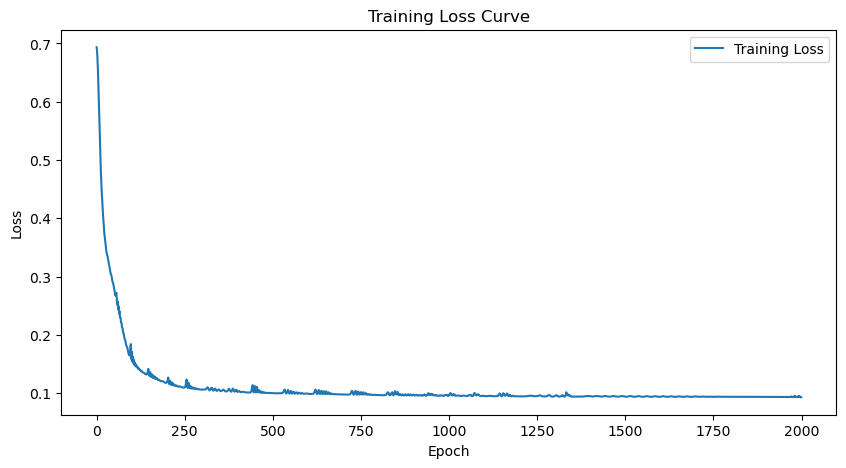

Final Model Accuracy: 78.68%
Final Model F1-score: 0.8029


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 78.68%
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.77       194
non_infringement       0.73      0.89      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



/tmp/ipykernel_1699724/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
